<a href="https://colab.research.google.com/github/bensenberner/airline-sentiment-prediction/blob/master/notebooks/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary (of the airline data-only model):
- Test accuracy is **83.2**
- Model tends to misclassify neutral tweets as negative

In [2]:
from fastai.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
data_path = 'drive/My Drive/airline-sentiment'
bs=24

# need to set a bunch of random seeds to ensure reproducibility
seed=42
import numpy
numpy.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)

In [3]:
def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

# Airline-LM -> Airline Classifier
## Created in [this notebook](https://colab.research.google.com/drive/1JajiCIdqAbJAOrRiRHrS99KTWjGnTf_8)
1. Predict the class labels for every row in the test set. I couldn't find a good method for doing this in fastai (loading data in fastai necessarily results in shuffling the data around when performing inference, which was unexpected). I figured I should use scikit-learn so that I could work directly with the data rather than using fastai wrappers which hide the data
2. Compute the [roc_auc score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for the model, which better describes the performance of a multiclass model than mere accuracy
3. Look at the confusion matrix
4. Attempt to understand the mistakes the model made

In [6]:
test_df = pd.read_csv(f'{data_path}/filtered_test.csv')

In [12]:
y_true = test_df['airline_sentiment']

In [ ]:
test_cls = load_learner(data_path, 'golden_cls')

In [ ]:
%%time
test_df_preds = [
  test_cls.predict(text)
  for idx, text in test_df['text'].items()
]

CPU times: user 3min 40s, sys: 1.11 s, total: 3min 41s
Wall time: 3min 41s


In [11]:
import pickle
with open(f'{data_path}/test_df_preds_raw.pkl', 'wb') as f:
  pickle.dump(test_df_preds, f, pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [4]:
with open(f'{data_path}/test_df_preds_raw.pkl', 'rb') as f:
    test_df_preds = pickle.load(f)

In [9]:
classes = ['negative', 'neutral', 'positive']
c2i = {classes[idx]: idx for idx in range(len(classes))}

In [60]:
y_score = np.array(
    [row[2].numpy() for row in test_df_preds]
)
y_score.to_csv(f'{data_path}/test_preds.csv')
y_score

,negative,neutral,positive
0,0.006222,0.006419,0.987359
1,0.944500,0.032219,0.023281
2,0.971989,0.013686,0.014325
3,0.022864,0.973220,0.003917
4,0.045395,0.904883,0.049722
...,...,...,...
1459,0.200856,0.284495,0.514649
1460,0.719159,0.181671,0.099170
1461,0.005528,0.019091,0.975381
1462,0.977795,0.011282,0.010923


These classification scores for each of the three predicted labels contain richer information than the "hard" label of the argmax predicted label.

It's possible that someone using this model might want to mess around with the thresholds for producing labels - for example, they might want to make sure that of all the times someone makes a positive tweet, this model picks up on it, even if that means the model erroneously misclassifies a few more negative/neutral tweets as positive, which amounts to lowering the threshold for classifying tweets as positive.

To get a full picture of how this model would perform for different threshold settings, we compute the area under the receiver operating curve.

In [59]:
y_score = pd.read_csv(f'{data_path}/test_preds.csv', index_col=0)

In [51]:
test_df['pred_sentiment'] = y_pred = pd.Series([str(row[0]) for row in test_df_preds])

First, we need to create a 1-hot encoded matrix to represent the true labels of the test set

In [58]:
y_true_onehot = np.array(
  [
      [int(idx == c2i.get(sent)) for idx in range(3)]
      for _, sent in test_df['airline_sentiment'].items()        
  ]
)
y_true_onehot

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0]])

## Computing roc auc score

In [66]:
from sklearn.metrics import roc_auc_score
roc_auc_score(
    y_true=y_true,
    y_score=y_score,
    average='weighted', # classes are imbalanced, so we weight by support
    multi_class='ovr'
)

0.9322194486626809

A random model would have a score of 0.5, and a perfect model would have 1.0. So this looks pretty good!

Accuracy is not a good measure since the classes are imbalanced - it might mask very poor performance on minority classes with exceptional performance on the majority class. Let's take a look at the full classification report.

## Classification Report

In [77]:
print(classification_report(y_true=y_true, y_pred=test_df_label_preds))
baseline_acc = test_df['airline_sentiment'].value_counts()['negative'] / test_df.shape[0]
test_acc = accuracy_score(y_true, y_pred)
print(f"Model accuracy:\t\t\t\t\t{test_acc}")
print(f"Baseline accuracy (all preds are negative):\t{baseline_acc}")

              precision    recall  f1-score   support

    negative       0.90      0.90      0.90       924
     neutral       0.69      0.66      0.68       302
    positive       0.76      0.79      0.77       238

    accuracy                           0.83      1464
   macro avg       0.78      0.78      0.78      1464
weighted avg       0.83      0.83      0.83      1464

Model accuracy:					0.8326502732240437
Baseline accuracy (all preds are negative):	0.6311475409836066


Despite having more support than positives, neutrals are the most difficult to classify correctly. This makes intuitive sense since neutrality is a "borderline" sentiment between positive and negative -- our classes are not independent, there isn't really such a thing as recognizable ["distinctly neutral" language](https://futurama.fandom.com/wiki/Neutral)

The lower f1 score for neutrals and positives makes sense for two quantitative reasons:
- Lower support than negatives
- As stated in the exploratory data analysis, the labels of neutral and positive tweets were characterized by less confidence (defined by the `airline_sentiment_confidence` feature) than negative tweets. So it would make sense for the model to be correspondingly "uncertain" about these labels. In fact, the f1 scores of the classes correspond to the relative "confidences" of each of the labels.

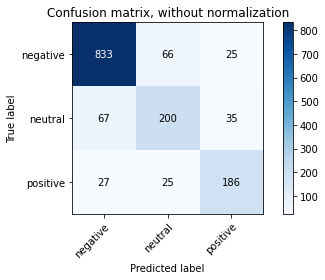

In [22]:
plot_confusion_matrix(
    y_true=y_true,
    y_pred=test_df_label_preds,
    classes=classes
)

Neutral and positive tweets are most often classified as negative. This makes sense because negative is the majority class, so there is a non-uniform prior regarding the sentiment of tweets.

Let's look at some of these neutral tweets that were misclassified. Refer back to the exploratory data analysis notebook to get a sense of what "neutrality" means.

## Analysis of mistakes

In [ ]:
test_df_with_scores = test_df.join(y_score)

In [59]:
true_neutral_pred_negative = test_df_with_scores[
  (test_df_with_scores['airline_sentiment'] == 'neutral')
  & (test_df_with_scores['pred_sentiment'] == 'negative')
].sort_values(by='negative', ascending=False)
true_neutral_pred_negative

,airline_sentiment,text,pred_sentiment,negative,neutral,positive
524,neutral,"@AmericanAir the dinner and called me ""hon"". N...",negative,0.991260,0.008474,0.000267
1277,neutral,@AmericanAir the motor that usually starts the...,negative,0.989806,0.007213,0.002981
262,neutral,@united - Group 2 line gets longer every week....,negative,0.986852,0.010795,0.002353
130,neutral,@JetBlue try harder. Take a winners attitude t...,negative,0.985610,0.005565,0.008826
1341,neutral,@united ^JT is the ORD to PHL flight at 9:15 P...,negative,0.982672,0.017128,0.000200
...,...,...,...,...,...,...
650,neutral,@united 374 ORD to ROC. Fam came to see me at ...,negative,0.517043,0.264019,0.218938
1218,neutral,@USAirways really!??,negative,0.512897,0.259309,0.227793
764,neutral,@SouthwestAir employees spreading a bit of #Ma...,negative,0.511050,0.458484,0.030466
835,neutral,@USAirways @OBJ_3 even airlines are scheming t...,negative,0.439078,0.433077,0.127845


In [63]:
for idx, text in true_neutral_pred_negative['text'].iloc[:10].items():
  print(text)

@AmericanAir the dinner and called me "hon". Not the service I would expect from 1st class.  #disappointed
@AmericanAir the motor that usually starts the engine is broke and @CVGairport ground crew failed to do it on time, per pilot #maintenance
@united - Group 2 line gets longer every week. Almost no one left for Groups 3-5 anymore. Time to make Explorer Card Group 3?
@JetBlue try harder. Take a winners attitude to your work.
@united ^JT is the ORD to PHL flight at 9:15 PM (CDT) delayed? DM I'm kinda hoping not to be stranded at ORD either.
@united you know what would be awesome? Providing us with complimentary entertainment on your flights. Especially those longer than 6 hours.
@SouthwestAir  Tried to DM you, it won't let me as it says you are not following me.
@JetBlue i'm getting info from the website, but needing to check it and the alerts would be much more beneficial.
@JetBlue  Brazil to volunteer teaching english &amp; spanish to Poor children so they have a skills to improve t

Manual analysis of each of the top ten:
1. Definitely a complaint, this is mislabeled
2. Seems to be complaining about a failure to meet expectations, but I guess this is more of a statement of fact rather than a complaint. Still, the word "failed" is pretty negative, so I would say this is negative.
3. Complaining about a line getting longer seems negative, even though they're offering a suggestion of how to improve. Not angry. Pointing out a problem but offering a solution is neutral, I guess.
4. Encouraging jetblue to try harder implies that jetblue is not doing well enough. I would say this is negative.
5. This person is asking a question, although they seem worried. I can see why this is a borderline neutral.
6. This person is clearly dissatisfied with the lack of entertainment on long flights. I'd say this is a mislabel.
7. This one doesn't seem *that* negative. A little inconvenienced, but handling the logistics of following doesn't seem as strong as "my flight has been delayed for 18 hours, what the hell??"
8. This person is dissatisfied with something, but I guess it's neutral because they're not too angry
9. This one seems...positive. But also random.
10. This one does seem to be negative regarding msgs being delayed

Of these top ten, I would say:
5 were mislabeled, should've been negative
1 was mislabeled and should've been positive
4 were more "statements of facts" and weren't bringing invective down upon the airlines...but those statements weren't as neutral as a headline.

Only the Brazil one strikes me as an obvious mistake (on the part of the labeler and the model). Maybe the presence of "poor" is what did it (e.g. 'poor customer service'?)

# Airline+Sentiment-140-LM -> Airline Classifier
## Created in [this notebook](https://colab.research.google.com/drive/1aUR5SMfSXNUaJgnhSpLhiMquWTjeir8K)
I'll include a test of this classifier for the sake of completedness, although I don't have high hopes based on its performance on its own validation set.

In [4]:
cls = load_learner(data_path, 'sent140_cls')

In [5]:
test_df = pd.read_csv(f'{data_path}/filtered_test.csv')

In [7]:
%%time
sent140_preds = [
  cls.predict(text)
  for idx, text in test_df['text'].items()
]
import pickle
with open(f'{data_path}/sentiment140_test_preds.pkl', 'wb') as f:
  pickle.dump(sent140_preds, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 4min 18s, sys: 641 ms, total: 4min 19s
Wall time: 4min 20s


/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [11]:
sent140_y_scores = np.array(
    [row[2].numpy() for row in sent140_preds]
)

In [13]:
sent140_y_pred = pd.Series([str(row[0]) for row in sent140_preds])

In [24]:
sent140_y_true = test_df['airline_sentiment'].apply(lambda x: c2i.get(x))

In [14]:
sent140_onehot_y_true = np.array(
  [
      [int(idx == c2i.get(sent)) for idx in range(3)]
      for _, sent in test_df['airline_sentiment'].items()        
  ]
)

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(
    y_true=sent140_onehot_y_true,
    y_score=sent140_y_scores,
    average='weighted', # classes are imbalanced, so we weight by support
    multi_class='ovo'
)

0.582486083046876

much worse than before.

In [27]:
print(classification_report(y_true=test_df['airline_sentiment'], y_pred=sent140_y_pred))

              precision    recall  f1-score   support

    negative       0.68      0.87      0.76       924
     neutral       0.38      0.16      0.23       302
    positive       0.34      0.20      0.25       238

    accuracy                           0.62      1464
   macro avg       0.46      0.41      0.41      1464
weighted avg       0.56      0.62      0.57      1464



Very bad at predicting the minority classes

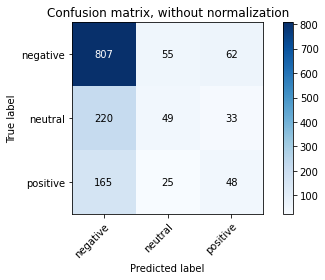

In [28]:
plot_confusion_matrix(
    y_true=test_df['airline_sentiment'],
    y_pred=sent140_y_pred,
    classes=classes
)

Overpredicts the majority class, as described above

In [40]:
import itertools
for (_, text), scores in itertools.islice(zip(test_df['text'].items(), sent140_y_scores), 10):
  print(f"Scores:{scores}|{text}")

Scores:[0.953346 0.029386 0.017268]|@SouthwestAir you're my early frontrunner for best airline! #oscars2016
Scores:[0.922252 0.06513  0.012618]|@USAirways how is it that my flt to EWR was Cancelled Flightled yet flts to NYC from USAirways are still flying?
Scores:[0.900395 0.005409 0.094197]|@JetBlue what is going on with your BDL to DCA flights yesterday and today?! Why is every single one getting delayed?
Scores:[0.533777 0.407007 0.059216]|@JetBlue do they have to depart from Washington, D.C.??
Scores:[0.979549 0.00416  0.016291]|@JetBlue I can probably find some of them. Are the ticket #s on there?
Scores:[0.922707 0.062335 0.014958]|@united still waiting to hear back. My wallet was stolen from one of your planes so would appreciate a resolution here
Scores:[0.95116  0.047479 0.00136 ]|@united Yes my flight was rebooked. I'm just losing trust in you if I want to get anywhere on time.
Scores:[0.977116 0.015543 0.007342]|@JetBlue Thank you ! What about Paris ? Could we arrange someth

Some of these are positive e.g "thank you!" and yet the classifier uniformly predicts that they are negative. Not good.